# Assessing CM2.6 for WMT analysis

- [ ] Do currents looks similar to obs?
- [ ] Is deep water forming in the right place?
- [ ] Is temperature/salinity structure similar to observational products?

In [2]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(20)
client = cluster.get_client()

In [66]:
client.close()
cluster.close()

In [3]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.7de0a5e9f9584c0a8e3ec10a4ddad962 Dashboard: /services/dask-gateway/clusters/staging.7de0a5e9f9584c0a8e3ec10a4ddad962/status,Cluster Workers: 1 Cores: 2 Memory: 8.00 GiB


In [4]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
import gcsfs

In [5]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/climate.yaml")
ds  = cat.GFDL_CM2_6()

url_budgets = "gs://cmip6/GFDL_CM2_6/control/ocean_budgets"
fs = gcsfs.GCSFileSystem()
budgets = xr.open_zarr(fs.get_mapper(url_budgets), consolidated=True)

url_control_surf = "gs://cmip6/GFDL_CM2_6/control/surface"
ctrl_surf = xr.open_zarr(fs.get_mapper(url_control_surf), consolidated=True)

url_control_ocean = "gs://cmip6/GFDL_CM2_6/control/ocean"
ctrl_ocean = xr.open_zarr(fs.get_mapper(url_control_ocean), consolidated=True)

url_control_ocean_3d = "gs://cmip6/GFDL_CM2_6/control/ocean_3d"
ctrl_ocean_3d = xr.open_zarr(fs.get_mapper(url_control_ocean_3d), consolidated=True)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/coding/times.py:517: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


# Checking BWF

In [22]:
ds

,unique
institution_id,1
source_id,1
experiment_id,3
variable_id,7
zstore,13


In [9]:
dict(ds)

{'NOAA-GFDL.GFDL-CM2.6.control': <name: NOAA-GFDL.GFDL-CM2.6.control, assets: 6,
 'NOAA-GFDL.GFDL-CM2.6.grid': <name: NOAA-GFDL.GFDL-CM2.6.grid, assets: 1,
 'NOAA-GFDL.GFDL-CM2.6.one_percent': <name: NOAA-GFDL.GFDL-CM2.6.one_percent, assets: 6}

In [23]:
budgets.attrs

{'NCO': '4.1.0',
 'filename': '01810101.ocean_budgets.nc',
 'grid_tile': '1',
 'grid_type': 'mosaic',
 'history': 'Tue Dec 10 21:44:49 2013: ncks --64bit --hdr_pad 15000 -A uhrho_et.tmp.nc wrhot.tmp.nc\nTue Dec 10 21:15:48 2013: ncra -O -v uhrho_et,nv,time_bounds 01810101/01810101.ocean_budgets.nc 01810101/uhrho_et.tmp.nc',
 'nco_openmp_thread_number': 1,
 'title': 'CM2.6_miniBling'}

In [7]:
ctrl_surf.surface_salt

<xarray.DataArray 'surface_salt' (time: 7305, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<xarray-surface_salt, shape=(7305, 2700, 3600), dtype=float32, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      Practical Salinity
    time_avg_info:  average_T1,average_T2,average_DT
    units:          psu
    valid_range:    [-10.0, 100.0]

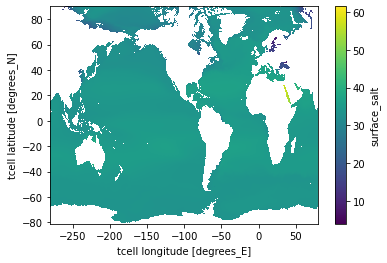

In [8]:
ctrl_surf.surface_salt.mean(dim='time').plot()

In [17]:
ctrl_surf.surface_salt[0]

<xarray.DataArray 'surface_salt' (yt_ocean: 2700, xt_ocean: 3600)>
dask.array<getitem, shape=(2700, 3600), dtype=float32, chunksize=(2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    time      object 0181-01-01 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      Practical Salinity
    time_avg_info:  average_T1,average_T2,average_DT
    units:          psu
    valid_range:    [-10.0, 100.0]

In [42]:
ctrl_surf.surface_salt[0].isel(yt_ocean=448)

<xarray.DataArray 'surface_salt' (xt_ocean: 3600)>
dask.array<getitem, shape=(3600,), dtype=float32, chunksize=(3600,), chunktype=numpy.ndarray>
Coordinates:
    time      object 0181-01-01 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    yt_ocean  float64 -62.03
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      Practical Salinity
    time_avg_info:  average_T1,average_T2,average_DT
    units:          psu
    valid_range:    [-10.0, 100.0]

In [6]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-81.11
upper_lat = 448 #-62.03
left_lon =  2149 #-65.05
right_lon = 3100 #30.05

lower_lat_u = 0 #-81.087512
upper_lat_u = 448 #-62.0079602 python is right exclusive so will have -62.0 5485892in array
left_lon_u = 2149 #-64.9 python is right exclusive so will have -65.0 in array
right_lon_u = 3100 #30.1 python is right exclusive so will have 30.0˚E

In [7]:
## set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

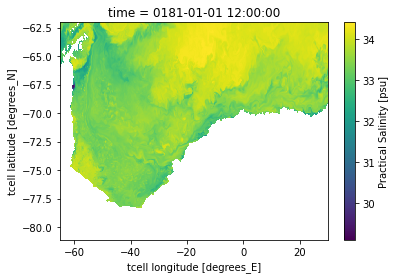

In [45]:
ctrl_surf.surface_salt[0].isel(**lat_range_no_u, **lon_range_no_u).plot()

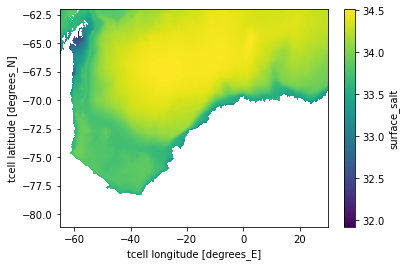

In [46]:
ctrl_surf.surface_salt.isel(**lat_range_no_u, **lon_range_no_u).mean(dim='time').plot()

In [8]:
ocean_salt_wg = ctrl_ocean.salt.isel(**lat_range_no_u, **lon_range_no_u)
ocean_3d_salt_wg = ctrl_ocean_3d.salt.isel(**lat_range_no_u, **lon_range_no_u)
ocean_temp_wg = ctrl_ocean.temp.isel(**lat_range_no_u, **lon_range_no_u)

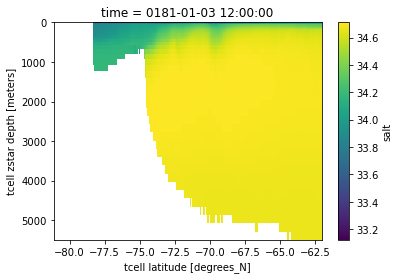

In [63]:
ocean_3d_salt_wg[0].mean(dim='xt_ocean').plot(yincrease=False)
#looks like it's producing some bw!

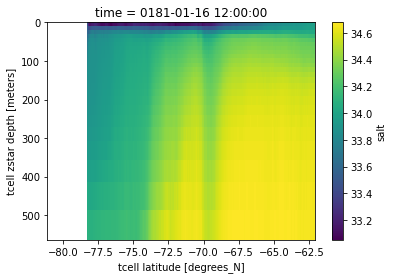

In [69]:
ocean_salt_wg[0, 0:24].mean(dim='xt_ocean').plot(yincrease=False)

# Checking if bottom temp and salt look similar to WOA

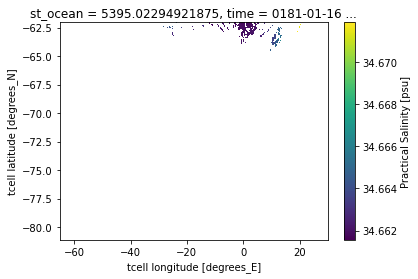

In [71]:
ocean_salt_wg[0,-1].plot()
#since it has nans built into data already you don't need separate grid/topo data to make bathymetry mask

In [8]:
#999 is ocean, 111 is land
hfacc = ocean_salt_wg.where(ocean_salt_wg == ocean_salt_wg.notnull(), 999).where(ocean_salt_wg < 999, 111)

In [73]:
#999 is ocean, 111 is land
depth_max = (ocean_salt_wg.st_ocean.where(hfacc == 999)).max(dim='st_ocean').load()

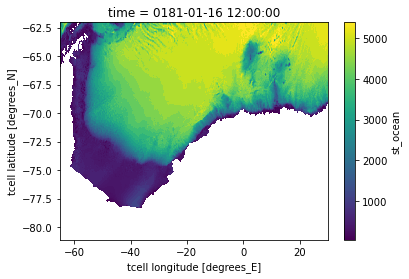

In [74]:
depth_max[0].plot()

In [76]:
depth_max = depth_max[0]

In [77]:
salt_mean = ocean_salt_wg.mean(dim='time').load()

In [82]:
temp_mean = ocean_temp_wg.mean(dim='time').load()

In [83]:
bottom_salt = salt_mean.sel(st_ocean=depth_max, method='nearest')
bottom_temp = temp_mean.sel(st_ocean=depth_max, method='nearest')

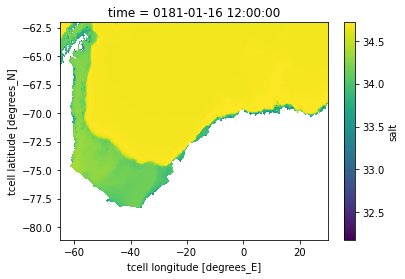

In [89]:
bottom_salt.plot()

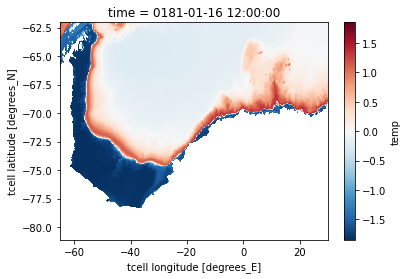

In [86]:
bottom_temp.plot()

In [9]:
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
#import plot_proj_to_latlon_grid

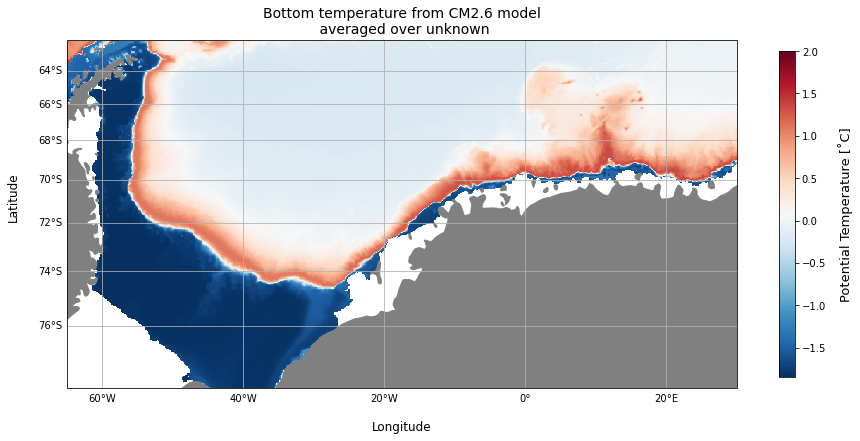

In [95]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ocean_temp_wg.xt_ocean, ocean_temp_wg.yt_ocean, bottom_temp, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom temperature from CM2.6 model\n averaged over unknown', fontsize=14);

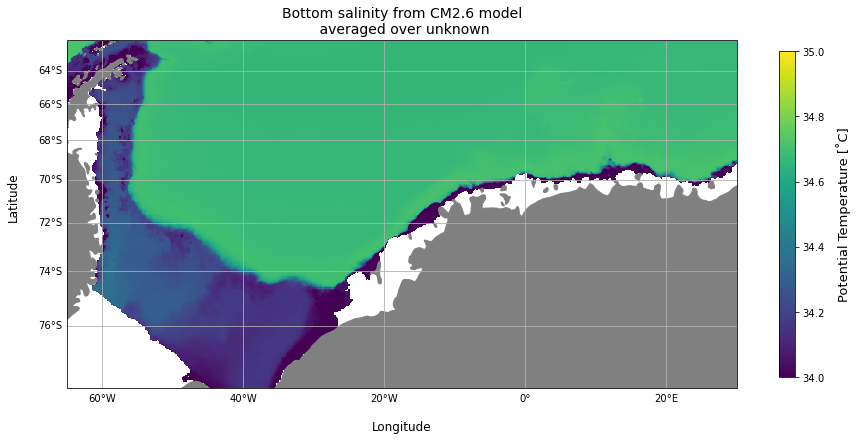

In [94]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ocean_salt_wg.xt_ocean, ocean_salt_wg.yt_ocean, bottom_salt, transform=ccrs.PlateCarree(), cmap='viridis', vmin=34, vmax=35)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from CM2.6 model\n averaged over unknown', fontsize=14);

# Checking currents

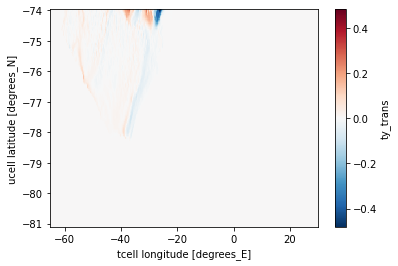

In [115]:
ctrl_ocean.ty_trans.isel(**lat_range_u, **lon_range_no_u).sum('st_ocean').mean(dim='time').plot()

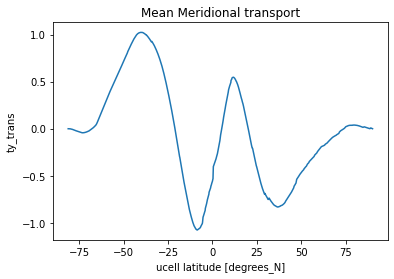

In [127]:
ctrl_ocean.ty_trans.sum(['st_ocean', 'xt_ocean']).mean(dim='time').plot()
plt.title('Mean Meridional transport');

In [128]:
ctrl_ocean.u

<xarray.DataArray 'u' (time: 240, st_ocean: 50, yu_ocean: 2700, xu_ocean: 3600)>
dask.array<xarray-u, shape=(240, 50, 2700, 3600), dtype=float32, chunksize=(1, 5, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    geolat_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
Attributes:
    cell_methods:   time: mean
    long_name:      i-current
    standard_name:  sea_water_x_velocity
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m/sec
    valid_range:    [-10.0, 10.0]

In [10]:
ctrl_ocean_wg = ctrl_ocean.isel(**lat_range, **lon_range)

In [10]:
import xgcm

grid_ocean_wg = xgcm.Grid(ctrl_ocean_wg, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                      'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                      'T': {'center': 'time'},
                                      'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                      'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_ocean_wg

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   st_edges_ocean --> right
  * right    st_ocean --> center
Zu Axis (not periodic, boundary=None):
  * center   sw_edges_ocean --> right
  * right    sw_ocean --> center

In [11]:
import pandas as pd

In [24]:
octo = pd.read_csv('https://raw.githubusercontent.com/pyclub-cu/classes/master/week%208%20data/octofriend.csv')
a_color = octo.loc[octo.color=='a'].index
octo.iloc[a_color, 2]=1

AttributeError: 'DataFrame' object has no attribute 'color'

In [15]:
octo

,x,y,z
0,124.849998,441.766666,a
1,117.849998,439.766666,a
2,110.849998,435.766663,a
3,102.849998,433.766663,a
4,92.849998,429.766663,a
...,...,...,...
1708,171.850006,332.766663,a
1709,171.850006,338.766663,a
1710,167.850006,343.766663,a
1711,164.850006,344.766663,a


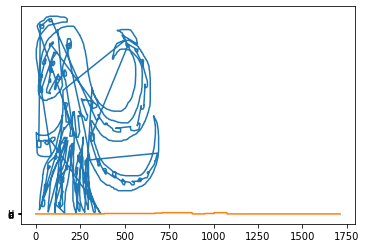

In [22]:
plt.plot(octo.x, octo.y, octo.z)

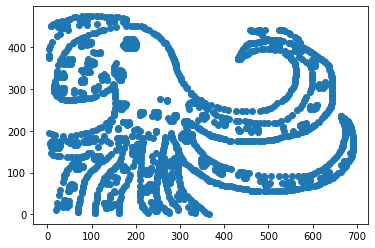

In [20]:
plt.scatter(octo.x, octo.y)

In [11]:
#divergence
du = grid_ocean_wg.diff(ctrl_ocean_wg.u, 'X')
dv = grid_ocean_wg.diff(ctrl_ocean_wg.v, 'Y', boundary='fill')

In [12]:
#calculating meters per latitudinal & longitudinal degree
earth_radius = 6.371e6
earth_circumference = 2*np.pi*earth_radius
meters_per_degree = earth_circumference / 360
meters_per_degree

111194.92664455873

In [13]:
#converting lat from degrees to meters
delta_lat = grid_ocean_wg.diff(ctrl_ocean_wg.yt_ocean, 'Y', boundary='fill', fill_value=np.nan)
dy = delta_lat * meters_per_degree
delta_lat_u = grid_ocean_wg.diff(ctrl_ocean_wg.yu_ocean, 'Y', boundary='fill', fill_value=np.nan)
dy_u = delta_lat_u * meters_per_degree

#converting degrees lon to lon [meters] (pinching at the poles)
delta_lon = grid_ocean_wg.diff(ctrl_ocean_wg.xt_ocean, 'X', boundary_discontinuity=360)
dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ctrl_ocean_wg.yt_ocean))
delta_lon_u = grid_ocean_wg.diff(ctrl_ocean_wg.xu_ocean, 'X', boundary_discontinuity=360)
dx_u = delta_lon_u * meters_per_degree * np.cos(np.deg2rad(ctrl_ocean_wg.yu_ocean))

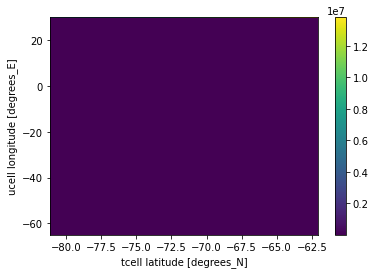

In [14]:
dx.plot()

In [15]:
dz = grid_ocean_wg.diff(ctrl_ocean_wg.st_edges_ocean[1:], 'Z', boundary='fill', fill_value=0.)
dz_u = grid_ocean_wg.diff(ctrl_ocean_wg.sw_edges_ocean[1:], 'Zu', boundary='fill', fill_value=0.)

In [18]:
dv_interp = grid_ocean_wg.interp(dv, 'Y', boundary='fill')
du_interp = grid_ocean_wg.interp(du, 'X')
dx_interp = grid_ocean_wg.interp(dx, 'Y', boundary='fill')

In [19]:
div_uv = (du_interp/dx_interp) - (dv_interp/dy)

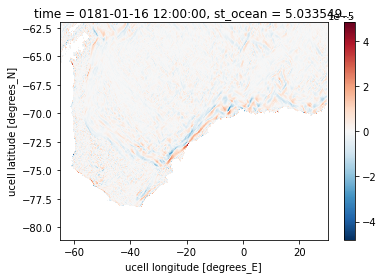

In [20]:
div_uv[0,0].plot()

In [22]:
client.restart()

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.e89dfabd3dbf4e60a04e84c473bd11ab Dashboard: /services/dask-gateway/clusters/staging.e89dfabd3dbf4e60a04e84c473bd11ab/status,Cluster Workers: 20 Cores: 40 Memory: 160.00 GiB


In [ ]:
div_uv.sum('st_ocean').mean(dim='time').plot()

In [12]:
u_mean = ctrl_ocean_wg.u.mean(dim=['time']).sum('st_ocean').load()
v_mean = ctrl_ocean_wg.v.mean(dim=['time']).sum('st_ocean').load()

In [21]:
u_mean[np.arange(0,448,10), np.arange(0,951, 10)]

<xarray.DataArray 'u' (yu_ocean: 45, xu_ocean: 96)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.7353871 , -0.1267122 , -0.26518252, ..., -0.59380525,
        -0.43411228, -0.04798275],
       [-0.19721045, -1.2659264 , -1.3598385 , ...,  0.46116203,
         0.33507174,  0.46605164],
       [ 1.8008064 ,  1.009929  , -0.78835887, ...,  0.5036754 ,
         0.3802748 ,  0.24126458]], dtype=float32)
Coordinates:
    geolat_c  (yu_ocean, xu_ocean) float32 nan nan nan ... -62.38 -62.38 -62.38
    geolon_c  (yu_ocean, xu_ocean) float32 nan nan nan nan ... 28.0 29.0 30.0
  * xu_ocean  (xu_ocean) float64 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0
  * yu_ocean  (yu_ocean) float64 -81.09 -80.67 -80.24 ... -63.29 -62.84 -62.38

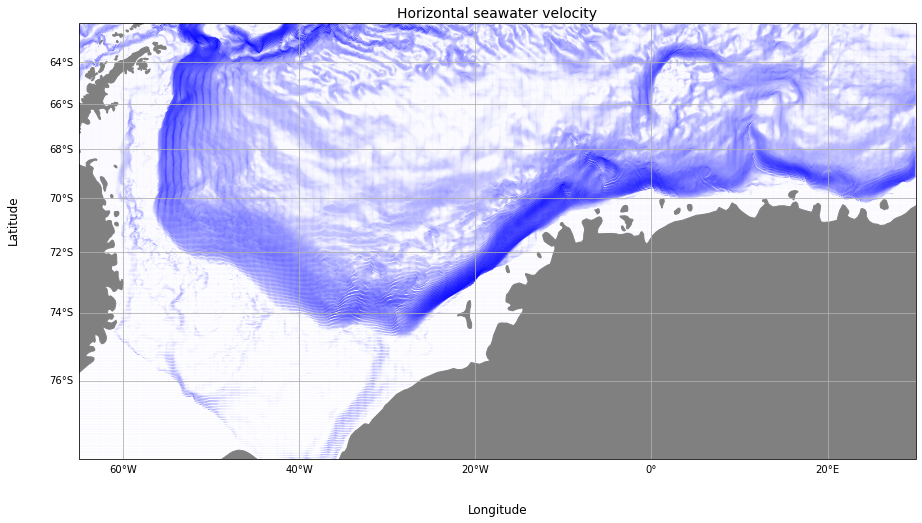

In [15]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.quiver(ctrl_ocean_wg.xu_ocean, ctrl_ocean_wg.yu_ocean, u_mean.values, v_mean.values, width=0.0002,
               transform=ccrs.PlateCarree(), color=(['blue']))#, 'green', 'red']))#, vmin=34, vmax=35)
#cb = fig.colorbar(im, ax=ax, shrink=0.4)
#cb.set_label("horizontal currents", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Horizontal seawater velocity', fontsize=14);

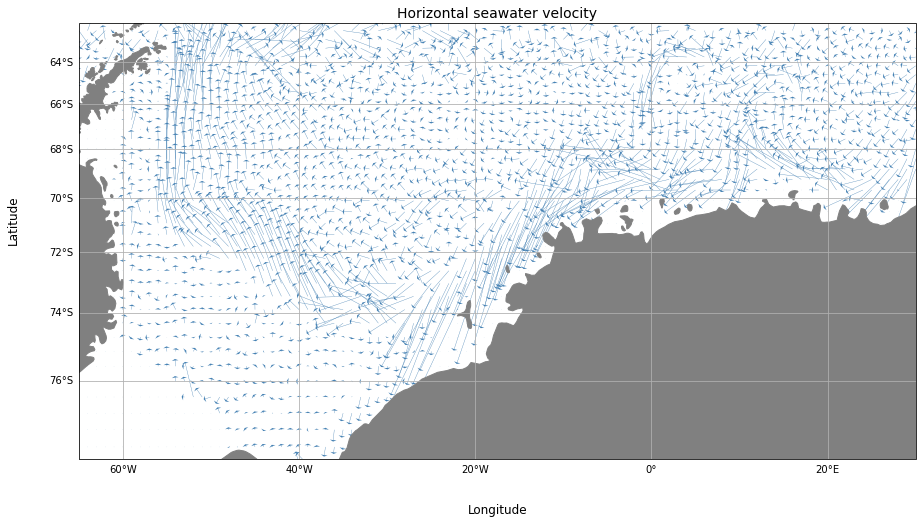

In [65]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.quiver(ctrl_ocean_wg.xu_ocean[np.arange(0,951,10)], ctrl_ocean_wg.yu_ocean[np.arange(0,448,10)], 
               u_mean[np.arange(0,448,10), np.arange(0,951, 10)].values, 
               v_mean[np.arange(0,448,10), np.arange(0,951, 10)].values, width=0.0004, headwidth=20,
               transform=ccrs.PlateCarree(), color=(['steelblue']))#, vmin=34, vmax=35)
#cb = fig.colorbar(im, ax=ax, shrink=0.4)
#cb.set_label("horizontal currents", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Horizontal seawater velocity', fontsize=14);